# Installation
CNGI documentation is located here:
CNGI documentation is located here:
[https://cngi-prototype.readthedocs.io/en/latest/index.html](https://cngi-prototype.readthedocs.io/en/latest/index.html)

For this demonstration we will use the data from the ALMA First Look at Imaging CASAguide

Refer to the Visibility Overview example notebook for an introduction to the basics of creating and handling visibility data.


In [1]:
import os

print("installing cngi (takes a few minutes)...")
os.system("apt-get install libgfortran3")
os.system("pip install --index-url https://casa-pip.nrao.edu/repository/pypi-casa-release/simple casatools==6.0.0.27")
os.system("pip install cngi-prototype==0.0.35")

print("downloading MeasurementSet from CASAguide First Look at Imaging...")
os.system("wget https://bulk.cv.nrao.edu/almadata/public/working/sis14_twhya_calibrated_flagged.ms.tar")
os.system("tar -xvf sis14_twhya_calibrated_flagged.ms.tar")

print('complete')

installing cngi (takes a few minutes)...
downloading MeasurementSet from CASAguide First Look at Imaging...
complete


In [4]:
from cngi.conversion import ms_to_zarr
from cngi.dio import read_vis

ms_to_zarr('sis14_twhya_calibrated_flagged.ms')
vis_xds = read_vis('sis14_twhya_calibrated_flagged.vis.zarr', ddi=0)
global_xds = read_vis('sis14_twhya_calibrated_flagged.vis.zarr', ddi='global')

processing sis14_twhya_calibrated_flagged.ms 
writing global partition
meta data processing time  0.6532080173492432
**********************************
Processing ddi 0
Selecting and sorting time  0.027091264724731445
n_time: 410   n_baseline: 210   n_chan: 384   n_pol: 2  chunking:  (100, 400, 20, 1)
Completed ddi 0  process time  20.49195098876953
**********************************


# Channel Averaging

the channel averaging function looks for all data variables in the dataset with a channel dimension and averages by the specified bin width

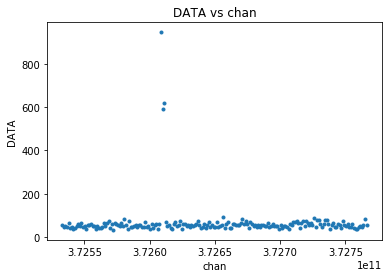

/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


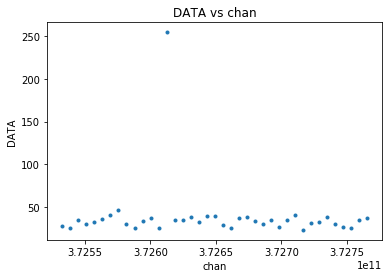

In [40]:
from cngi.vis import chanaverage, visualize

# average 5 channels of original unflagged data
avg_xds = chanaverage(vis_xds, width=5)

# compare the original to the channel averaged
visualize(vis_xds.DATA[:,34], 'chan')
visualize(avg_xds.DATA[:,34], 'chan')

In [8]:
# confirm new channel dimension after averaging
# TODO: keep extra coordinates
print(dict(vis_xds.dims))
print(dict(avg_xds.dims))

{'baseline': 210, 'chan': 384, 'pair': 2, 'pol': 2, 'receptor': 2, 'spw': 1, 'time': 410, 'uvw_index': 3}
{'baseline': 210, 'chan': 77, 'pol': 2, 'time': 410, 'uvw_index': 3}


Since every variable with a channel dimension in the dataset is averaged, this will also include the FLAG variable.  FLAG is a boolean type with values of 0 or 1 that are averaged over the width, resulting in a decimal number.  The result is then typcast back to boolean, which is the same as just rounding up.

Long story short, if any channel in the width is flagged, the resulting averaged channel will also be flagged

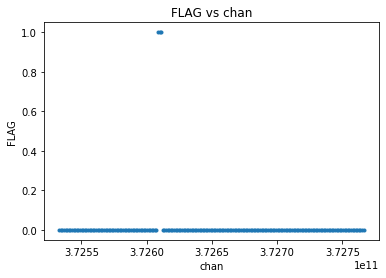

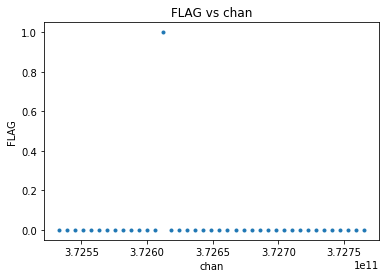

In [9]:
# compare the original flags to the channel averaged flags
visualize(vis_xds.FLAG[:,34], 'chan')
visualize(avg_xds.FLAG[:,34], 'chan')

One might want to apply flags before channel averaging

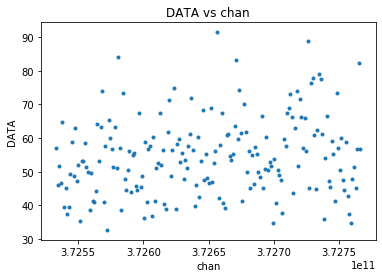

/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


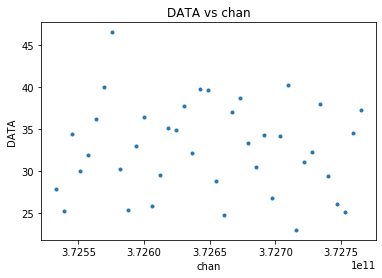

In [34]:
from cngi.vis import applyflags

flg_xds = applyflags(vis_xds, flags=['FLAG'])
avg_flg_xds = chanaverage(flg_xds, width=5)

visualize(flg_xds.DATA[:,34], 'chan')
visualize(avg_flg_xds.DATA[:,34], 'chan')

Applying flags before or after channel averaging yields the same results

/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


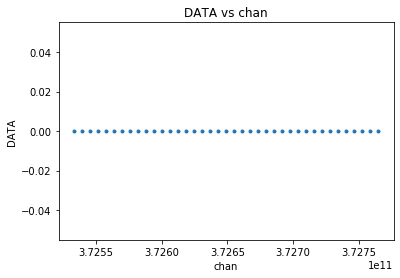

In [44]:
flg_avg_xds = applyflags(avg_xds, flags=['FLAG'])

# diff the two methods
visualize(avg_flg_xds.DATA - flg_avg_xds.DATA, 'chan')

# Time Averaging

the time averaging function looks for all data variables in the dataset with a time dimension and averages by the specified bin width.  Spanning across states within a scan, scans of a each state, or both yields different results.

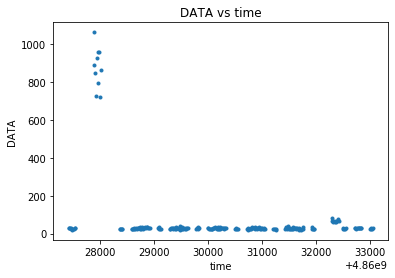

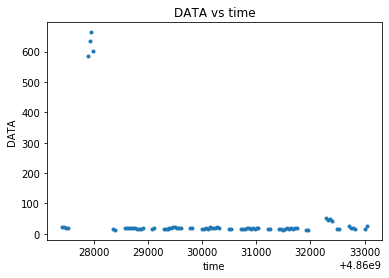

In [58]:
from cngi.vis import timeaverage, visualize

# average 5 time steps, don't span anything (separate by scan and state)
avg_xds = timeaverage(vis_xds, width=5, timespan='none')

# compare the original to the time averaged
visualize(vis_xds.DATA[:,:,128], 'time')
visualize(avg_xds.DATA[:,:,128], 'time')

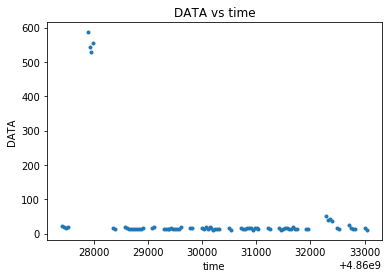

In [59]:
# average 5 time steps spanning states within each scan
state_avg_xds = timeaverage(vis_xds, width=5, timespan='state')

visualize(state_avg_xds.DATA[:,:,128], 'time')

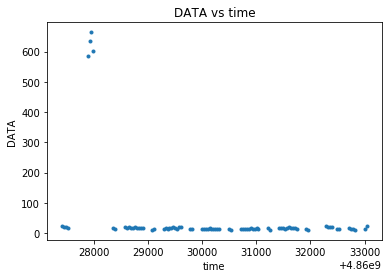

In [60]:
# average 5 time steps spanning all scans per state
scan_avg_xds = timeaverage(vis_xds, width=5, timespan='scan')

visualize(scan_avg_xds.DATA[:,:,128], 'time')

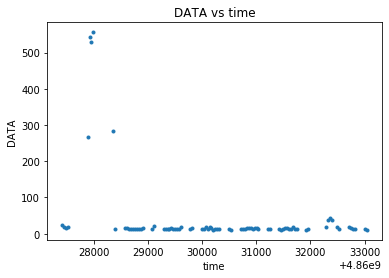

In [61]:
# average 5 time steps spanning all scans and states
both_avg_xds = timeaverage(vis_xds, width=5, timespan='both')

visualize(both_avg_xds.DATA[:,:,128], 'time')

Flagging works the same way as in channel averaging.  Flags are averaged with all other data sharing the time axis.  They may be applied before or after with the same results.

/usr/local/lib/python3.6/dist-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


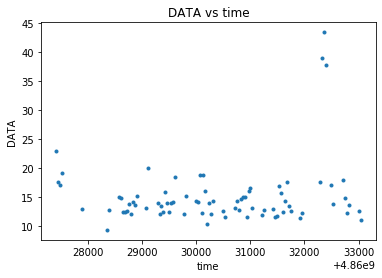

/usr/local/lib/python3.6/dist-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


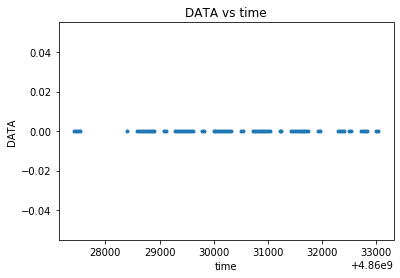

In [62]:
from cngi.vis import applyflags

flg_xds = applyflags(vis_xds, flags=['FLAG'])

avg_flg_xds = timeaverage(flg_xds, width=5, timespan='both')
flg_avg_xds = applyflags(both_avg_xds, flags=['FLAG'])

visualize(avg_flg_xds.DATA[:,:,128], 'time')
visualize(avg_flg_xds.DATA[:,:,128] - flg_avg_xds.DATA[:,:,128], 'time')